In [1]:
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf
#import tensorflow_probability as tfp


sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


## Utility scripts

In [2]:
%run src/layers/zoneout.py
%run src/layers/adabound.py
#%run src/layers/adabelief.py
%run src/layers/convgru.py
%run src/layers/dropblock.py
%run src/layers/extra_layers.py
%run src/layers/stochastic_weight_averaging.py
%run src/preprocessing/indices.py
%run src/preprocessing/slope.py
%run src/utils/metrics.py
%run src/utils/lovasz.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [3]:
%run src/layers/adabelief.py

# Hyperparameter definitions

In [4]:
ZONE_OUT_PROB = 0.9

ACTIVATION_FUNCTION = 'swish'

INITIAL_LR = 5e-5
DROPBLOCK_MAXSIZE = 4
DECONV = 'upconv'
N_CONV_BLOCKS = 1
FINAL_ALPHA = 0.33
LABEL_SMOOTHING = 0.1
BATCH_RENORM = 'renorm'

L2_REG = 0.
BN_MOMENTUM = 0.90
BATCH_SIZE = 20
MAX_DROPBLOCK = 0.8

GRU_FLT = 24
OUT_FLT = 48

IMAGE_SIZE = 24
LABEL_SIZE = 14
LEN = 4

# Custom layer definitions

### Utility blocks (Batch norm, cSSE, etc.)

In [5]:
def cse_block(prevlayer, prefix):
    '''Channel excitation and spatial squeeze layer. 
       Calculates the mean of the spatial dimensions and then learns
       two dense layers, one with relu, and one with sigmoid, to rerank the
       input channels
       
         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the cse_block
    '''
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    '''Spatial excitation and channel squeeze layer.
       Calculates a 1x1 convolution with sigmoid activation to create a 
       spatial map that is multiplied by the input layer

         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the sse_block
    '''
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''Implementation of Concurrent Spatial and Channel 
       ‘Squeeze & Excitation’ in Fully Convolutional Networks
    
        Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): added output of cse and sse block
          
         References:
          https://arxiv.org/abs/1803.02579
    '''
    #cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    #x = Add(name=prefix + "_csse_mul")([cse, sse])

    return sse

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        print("ZERO PADDING")
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

### Conv GRU Block

In [6]:
def gru_block(inp, length, size, flt, scope, train, normalize = False):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print(f"GRU input shape {inp.shape}, zoneout: {0.5}")
        """
        cell_fw = ConvLSTMCell(shape = size, filters = flt,
                               kernel = [3, 3], forget_bias=1.0, 
                               activation=tf.tanh, normalize=True, 
                               peephole=False, data_format='channels_last', reuse=None)
        cell_bw = ConvLSTMCell(shape = size, filters = flt,
                               kernel = [3, 3], forget_bias=1.0, 
                               activation=tf.tanh, normalize=True, 
                               peephole=False, data_format='channels_last', reuse=None)
        """
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = True, sse = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = True, sse = True)
        zoneout = 0.75
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = zoneout, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = zoneout, is_training = train)
        print(inp.shape)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        print(f"Zoneout: {zoneout}")
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print(f"Down block output shape {gru.shape}")
    return gru, steps


def attention(inp, units):
    weighted = TimeDistributed(Conv2D(units, (1, 1), padding = 'same', kernel_initializer = tf.keras.initializers.Ones(),
                            activation = 'sigmoid', strides = (1, 1), use_bias = False, ))(inp) 
    alphas = tf.reduce_sum(weighted, axis = 1, keep_dims = True)
    alphas = weighted / alphas
    multiplied = tf.reduce_sum(alphas * inp, axis = 1)
    print(multiplied.shape)
    return multiplied

### Conv blocks

In [7]:
# Partial Conv

def ws_reg(kernel):
    kernel_mean = tf.math.reduce_mean(kernel, axis=[0, 1, 2], keepdims=True, name='kernel_mean')
    kernel = kernel - kernel_mean
  #kernel_std = tf.math.reduce_std(kernel, axis=[0, 1, 2], keepdims=True, name='kernel_std')
    kernel_std = tf.keras.backend.std(kernel, axis=[0, 1, 2], keepdims=True)
    kernel = kernel / (kernel_std + 1e-5)
    return kernel

class WSConv2D(tf.keras.layers.Conv2D):
    def __init__(self, *args, **kwargs):
        super(WSConv2D, self).__init__(kernel_initializer="he_normal", *args, **kwargs)

    def standardize_weight(self, weight, eps):

        mean = tf.math.reduce_mean(weight, axis=(0, 1, 2), keepdims=True)
        weight = weight - mean
        var = tf.keras.backend.std(weight, axis=[0, 1, 2], keepdims=True)
        weight = weight / (var + 1e-5)
        return weight

    def call(self, inputs, eps=1e-4):
        self.kernel.assign(self.standardize_weight(self.kernel, eps))
        return super().call(inputs)

class WSConv2D(tf.keras.layers.Conv2D):
    def __init__(self, filters,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 use_bias=False,
                 kernel_initializer='he_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(WSConv2D, self).__init__(filters=filters,
                 kernel_size=kernel_size,
                 strides=strides,
                 padding=padding,
                 data_format=data_format,
                 dilation_rate=dilation_rate,
                 activation=activation,
                 use_bias=use_bias,
                 kernel_initializer=kernel_initializer,
                 bias_initializer=bias_initializer,
                 kernel_regularizer=kernel_regularizer,
                 bias_regularizer=bias_regularizer,
                 activity_regularizer=activity_regularizer,
                 kernel_constraint=kernel_constraint,
                 bias_constraint=bias_constraint,
                 **kwargs)
        
    def standardize_weight(self, weight, eps):

        mean = tf.math.reduce_mean(weight, axis=(0, 1, 2), keepdims=True)
        weight = weight - mean
        var = K.sqrt(K.var(weight, axis=[0,1,2], keepdims=True) + 1e-8)
        weight = weight / (var + 1e-5)
        return weight

    def call(self, inputs):
        #weight = self.standardize_weight(self.kernel, 1e-5)

        outputs = K.conv2d(
            inputs,
            self.kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
    
class WSConv2D(tf.keras.layers.Conv2D):
    def __init__(self, *args, **kwargs):
        super(WSConv2D, self).__init__(kernel_initializer="he_normal", *args, **kwargs)

    def standardize_weight(self, weight, eps):

        mean = tf.math.reduce_mean(weight, axis=(0, 1, 2), keepdims=True)
        weight = weight - mean
        var = tf.keras.backend.std(weight, axis=[0, 1, 2], keepdims=True)
        weight = weight / (var + 1e-5)
        return weight

    def call(self, inputs, eps=1e-4):
        self.kernel.assign(self.standardize_weight(self.kernel, eps))
        return super().call(inputs)
    
def partial_conv(x, channels, kernel=3, stride=1, norm = True, use_bias=False, padding='SAME', scope='conv_0'):
    

    
    with tf.variable_scope(scope):
        if padding.lower() == 'SAME'.lower() :
            with tf.variable_scope('mask'):
                _, h, w, _ = x.get_shape().as_list()

                slide_window = kernel * kernel
                mask = tf.ones(shape=[1, h, w, 1])

                update_mask = tf.layers.conv2d(mask, filters=1,
                                               kernel_size=kernel, kernel_initializer=tf.constant_initializer(1.0),
                                               strides=stride, padding=padding, use_bias=False, trainable=False)

                mask_ratio = slide_window / (update_mask + 1e-8)
                update_mask = tf.clip_by_value(update_mask, 0.0, 1.0)
                mask_ratio = mask_ratio * update_mask

            with tf.variable_scope('x'):
                if 3 > 2:
                    x = WSConv2D(filters=channels, kernel_regularizer = None,
                                     kernel_size=kernel,
                                     strides=stride, padding=padding, use_bias=False).apply(x)
                else:
                    x = tf.layers.conv2d(x, filters=channels, kernel_regularizer = None,
                                     kernel_size=kernel, kernel_initializer=tf.keras.initializers.he_normal(),
                                     strides=stride, padding=padding, use_bias=False)
    
                x = x * mask_ratio
                
                

                if use_bias:
                    bias = tf.get_variable("bias", [channels], initializer=tf.constant_initializer(0.0))

                    x = tf.nn.bias_add(x, bias)
                    x = x * update_mask

        else :
            if 3 > 2:
                x = WSConv2D(filters=channels,kernel_regularizer = None,
                                 kernel_size=kernel,
                                 strides=stride, padding=padding, use_bias=use_bias).apply(x)
            else:
                x = tf.layers.conv2d(x, filters=channels,kernel_regularizer = None,
                                 kernel_size=kernel, kernel_initializer=tf.keras.initializers.he_normal(),
                                 strides=stride, padding=padding, use_bias=use_bias)

        return x
    


def conv_swish_gn(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 keep_rate,
                 stride = (1, 1),
                 activation = True,
                 use_bias = False,
                 norm = True,
                 dropblock = True,
                 csse = True,
                 weight_decay = None,
                 block_size = 5,
                 padding = "SAME",
                 partial = True, window_size = 5):
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization
          activation (bool): whether to apply RELU
          use_bias (str): whether to use bias. Should always be false

         Returns:
          bn (tf.Variable): output of Conv2D -> Batch Norm -> RELU
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    bn_flag = "Group Norm" if norm else ""
    activation_flag = "RELU" if activation else "Linear"
    csse_flag = "CSSE" if csse else "No CSSE"
    bias_flag = "Bias" if use_bias else "NoBias"
    drop_flag = "DropBlock" if dropblock else "NoDrop"
        
    
    print("{} {} Conv 2D {} {} {} {} {}".format(scope, kernel_size,
                                                   bn_flag, activation_flag,
                                                   csse_flag, bias_flag, drop_flag))
    
    with tf.variable_scope(scope + "_conv"):
        if not partial:
            conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),  strides = stride,
                          activation = None, padding = 'valid', use_bias = use_bias,
                          #kernel_regularizer = weight_decay,
                          kernel_initializer = tf.keras.initializers.he_normal())(inp)
        if partial:
            conv = partial_conv(inp, filters, kernel=kernel_size, stride=1, norm = norm,
                                use_bias= use_bias, padding=padding, scope = scope)
    if activation:
        conv = tf.nn.swish(conv)
    if dropblock:
        _mask = DropBlockMask(keep_prob=keep_rate, block_size= block_size)
        mask = _mask(conv, is_training)
    else:
        _mask = DropBlockMask(keep_prob=1., block_size= block_size)
        mask = _mask(conv, is_training)
    if norm:
        if filters > 80:
            G = 40
        if filters == 80:
            G = 20
        if filters == 40:
            G = 10
        #conv = tf.layers.batch_normalization(conv, training=is_training)
        conv = weighted_group_norm(x = conv, mask = mask, scope = scope, G = 8, window_size = window_size)
        #conv = group_norm(x = conv, scope = scope, G = 8, window_size = window_size)
        
    if csse:
        conv = csse_block(conv, "csse_" + scope)
    if dropblock: 
        with tf.variable_scope(scope + "_drop"):
            drop_block = DoDropBlock(keep_prob=keep_rate, block_size= block_size)
            #drop_block = DropBlock(keep_prob=keep_rate, block_size= block_size)
            conv = drop_block([conv, mask], is_training)
    return conv

# Model definition

## Placeholders

In [8]:
reg = tf.contrib.layers.l2_regularizer(0.)
temporal_model = True
input_size = 28
n_bands = 17
output_size = 14

if temporal_model:
    inp = tf.placeholder(tf.float32, shape=(None, LEN + 1, input_size, input_size, n_bands))
    length = tf.placeholder_with_default(np.full((1,), LEN + 1), shape = (None,))
else:
    inp = tf.placeholder(tf.float32, shape=(None, input_size, input_size, n_bands))
    
labels = tf.placeholder(tf.float32, shape=(None, output_size, output_size))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
is_training = tf.placeholder_with_default(False, (), 'is_training') # For DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.1, shape = ()) # For loss scheduling
init_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling
loss_weight = tf.placeholder_with_default(1.0, shape = ())
beta_ = tf.placeholder_with_default(0.0, shape = ()) # For loss scheduling, not currently implemented

INFO:tensorflow:Scale of 0 disables regularizer.


In [9]:
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock

## Layers

In [10]:
# master modmel is 32, 64, 96, 230k paramms
initial_flt = 64
mid_flt = initial_flt * 2
high_flt = initial_flt * 2 * 2
INPUT_SIZE = 28
SIZE_X = 28

#inp = ReflectionPadding5D((1, 1))(inp)
gru_input = inp[:, :-1, ...]
#gru_input = tf.concat([inp[:, :-1, ..., :10], inp[:, :-1, ..., 11:]], -1)
gru, steps = gru_block(inp = gru_input, length = length,
                            size = [INPUT_SIZE, SIZE_X, ], # + 2 here for refleclt pad
                            flt = initial_flt // 2,
                            scope = 'down_16',
                            train = is_training)
with tf.variable_scope("gru_drop"):
    _mask = DropBlockMask(keep_prob=keep_rate, block_size= 5)
    mask = _mask(gru, is_training)
    drop_block = DoDropBlock(keep_prob=keep_rate, block_size=5)
    gru = drop_block([gru, mask], is_training)
    
# Median conv
median_input = inp[:, -1, ...]
median_conv = conv_swish_gn(inp = median_input, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_median', filters = initial_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, window_size = 15)

print(f"Median conv: {median_conv.shape}")

concat1 = tf.concat([gru, median_conv], axis = -1)
concat = conv_swish_gn(inp = concat1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_concat', filters = initial_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, padding = "SAME", window_size = 15)
print(f"Concat: {concat.shape}")

    
# MaxPool-conv-swish-GroupNorm-csse
pool1 = MaxPool2D()(concat)
conv1 = conv_swish_gn(inp = pool1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv1', filters = mid_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True, padding = "VALID",
            csse = True, dropblock = True, weight_decay = None, window_size = 7)
print(f"Conv1: {conv1.shape}")

# MaxPool-conv-swish-csse-DropBlock
pool2 = MaxPool2D()(conv1)
conv2 = conv_swish_gn(inp = pool2, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv2', filters = high_flt, 
            keep_rate = keep_rate, activation = True,  use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, block_size = 4, padding = "VALID",
                     window_size = 1)
print("Encoded", conv2.shape)

# Decoder 4 - 8, upsample-conv-swish-csse-concat-conv-swish
up2 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(conv2)
#up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2', filters = mid_flt, 
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None, window_size = 3)
conv1_crop = Cropping2D(2)(conv1)
print(conv1_crop.shape)
up2 = tf.concat([up2, conv1_crop], -1)
#up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2_out', filters = mid_flt, 
                    keep_rate =  keep_rate, activation = True,  use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None, window_size = 3)

# Decoder 8 - 14 upsample-conv-swish-csse-concat-conv-swish
up3 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(up2)
#up3 = ReflectionPadding2D((1, 1,))(up3)
up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up3', filters = initial_flt, 
                    keep_rate = keep_rate, activation = True,  use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)
gru_crop = Cropping2D(6)(concat)
print(up3.shape)
print(gru_crop.shape)
up3 = tf.concat([up3, gru_crop], -1)

up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'out', filters = initial_flt, 
                    keep_rate  = keep_rate, activation = True,  use_bias = False, norm = True,
                    csse = True, dropblock = False, weight_decay = None, padding = "VALID")


#print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.68/0.32)]) # For focal loss
print(f"The output is {up2.shape}, with a receptive field of {1}")
fm = Conv2D(filters = 1,
            kernel_size = (1, 1),
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(up3) # For focal loss
#fm = Cropping2D(1)(fm)

print(f"The output, sigmoid is {fm.shape}, with a receptive field of {1}")

GRU input shape (?, 4, 28, 28, 17), zoneout: 0.5
(?, 4, 28, 28, 17)
(?, 4, 28, 28, 17)

(3, 3, 49, 64)
(3, 3, 49, 64)
Zoneout: 0.75
Down block output shape (?, 28, 28, 64)


conv_median 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Median conv: (?, 28, 28, 64)
conv_concat 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Concat: (?, 28, 28, 64)
conv1 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Conv1: (?, 12, 12, 128)
conv2 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Encoded (?, 4, 4, 256)
up2 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
(?, 8, 8, 128)
up2_out 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
up3 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
(?, 16, 16, 64)
(?, 16, 16, 64)
out 3 Conv 2D Group Norm RELU CSSE NoBias NoDrop
The output is (?, 8, 8, 128), with a receptive field of 1
The output, sigmoid is (?, 14, 14, 1), with a receptive field of 1


In [11]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print(f"This model has {total_parameters} parameters")

This model has 1277321 parameters


In [12]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def calc_mask(seg):

    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    loss_importance = np.array([x for x in range(0, 197, 1)])
    loss_importance = loss_importance / 196
    loss_importance = np.expm1(loss_importance)
    loss_importance[:30] = 0.

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    res[np.logical_and(res < 2, res > 0)] = 0.5
    res[np.logical_or(res >= 2, res <= 0)] = 1.
    return res

def calc_mask_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    bce_batch = np.array([calc_mask(y)
                     for y in y_true_numpy]).astype(np.float32)
    return bce_batch



def weighted_bce_loss(y_true, y_pred, weight, mask = True, smooth = 0.06):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
       
       For smoothing, we want to weight false positives as less important than
       false negatives, so we smooth false negatives 2x as much. 
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr):
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, 0.0125, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )

    return loss 


def calc_dist_map(seg):
    #Utility function for calc_dist_map_batch that calculates the loss
    #   importance per pixel based on the surface distance function
    
     #    Parameters:
    #      seg (arr):
     #     
    #     Returns:
    #      res (arr):
    #
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    mults = np.ones_like(seg)
    ones = np.ones_like(seg)
    for x in range(1, res.shape[0] -1 ):
        for y in range(1, res.shape[0] - 1):
            # If > 1 px, double the weight of the positive
            # If == 1 px, half the weight of the negative
            if seg[x, y] == 1:
                l = seg[x - 1, y]
                r = seg[x + 1, y]
                u = seg[x, y + 1]
                d = seg[x, y - 1]
                lu = seg[x - 1, y + 1]
                ru = seg[x + 1, y + 1]
                rd = seg[x + 1, y - 1]
                ld = seg[x -1, y - 1]
                
                sums = (l + r + u + d)
                sums2 = (l + r + u + d + lu + ru +rd + ld)
                if sums >= 2:
                    mults[x, y] = 2
                if sums2 <= 1:
                    ones[x - 1, y] = 0.5
                    ones[x + 1, y] = 0.5
                    ones[x, y + 1] = 0.5
                    ones[x, y - 1] = 0.5
                    ones[x - 1, y + 1] = 0.5
                    ones[x + 1, y + 1] = 0.5
                    ones[x + 1, y - 1] = 0.5
                    ones[x -1, y - 1] = 0.5

    if posmask.any():
        
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        # When % = 1, 0 -> 1.75
        # When % = 100, 0 -> 0
        res = np.round(res, 0)
        res[np.where(np.isclose(res, -.41421356, rtol = 1e-2))] = -1
        res[np.where(res == -1)] = -1 * mults[np.where(res == -1)]
        res[np.where(res == 0)] = -1  * mults[np.where(res == 0)]
        # When % = 1, 1 -> 0
        # When % = 100, 1 -> 1.75
        res[np.where(res == 1)] = 1 * ones[np.where(res == 1)]
        res[np.where(res == 1)] *= 0.67
        #res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = loss_importance[sums]
        
    res[np.where(res < -3)] = -3
    res[np.where(res > 3)] = 3
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    return res


def calc_dist_map_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    '''Calculates the mean surface loss for the input batch
       by multiplying the distance map by y_pred
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          loss (arr):
        
         References:
          https://arxiv.org/abs/1812.07032
    '''
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    y_true_dist_map = tf.stack(y_true_dist_map, axis = 0)
    multipled = y_pred * y_true_dist_map
    loss = tf.reduce_mean(multipled, axis = (1, 2, 3))
    return loss

def tf_percentile(x, p):
    with tf.name_scope('percentile'):
        y = tf.transpose(x)  # take percentile over batch dimension
        sorted_y = tf.sort(y)
        frac_idx = tf.cast(p, tf.float64) / 100. * (tf.cast(tf.shape(y)[-1], tf.float64) - 1.)
        return 0.5 * (  # using midpoint rule
            tf.gather(sorted_y, tf.cast(tf.math.ceil(frac_idx), tf.int32), axis=-1)
            + tf.gather(sorted_y, tf.cast(tf.math.floor(frac_idx), tf.int32), axis=-1))

def lovasz_surf(y_true, y_pred, alpha, weight, beta):
    
    #lv = lovasz_softmax(probas = y_pred,
    #                    labels = tf.reshape(y_true, (-1, 14, 14)), 
    #                    classes=[1],
    #                    per_image=False) 
    
    bce = weighted_bce_loss(y_true = y_true, 
                             y_pred = y_pred, 
                             weight = weight,
                             smooth = 0.0625)


    bce = tf.reduce_mean(bce, axis = (1, 2, 3))
    surface = surface_loss(tf.cast(tf.math.greater(y_true, 0.1), tf.float32), y_pred)
    surface = tf.reshape(surface, tf.shape(bce))
    print(surface.shape)

    bce = (1 - alpha) * bce
    surface_portion = alpha * surface
    
    #result = bce + lovasz
    result = bce + surface_portion
    #upper_bound = tf_percentile(result, 90)
    #result = tf.clip_by_value(result, tf.reduce_min(result), upper_bound)
    result = tf.reduce_mean(result)
    return result




In [13]:
def grad_norm(gradients):
        norm = tf.compat.v1.norm(
            tf.stack([
                tf.compat.v1.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm

FRESH_START = True
print(f"Starting model with: \n {ZONE_OUT_PROB} zone out \n {L2_REG} l2 \n"
      f"{INITIAL_LR} initial LR \n {total_parameters} parameters")  

finetune_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2d_15") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2d_17") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "outregressor") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_outregressor") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "outregressor_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "outregressor2") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_outregressor2") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2d_13") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up3") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up3_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up3") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_out_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up2_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up2")# + \

if FRESH_START:
    # We use the Adabound optimizer
    
    train_loss = lovasz_surf(tf.reshape(labels, (-1, 14, 14, 1)), 
                             fm, weight = loss_weight, 
                             alpha = alpha, beta = beta_)
    
    # If there is any L2 regularization, add it. Current model does not use
    #l2_loss = tf.losses.get_regularization_loss()
    #if len(tf.losses.get_regularization_losses()) > 0:
    #    train_loss = train_loss + l2_loss
        
    # If necessary to switch to SGD at any point, make that optimizer here
    
    
    
    test_loss = lovasz_surf(tf.reshape(labels, (-1, 14, 14, 1)),
                            fm, weight = loss_weight, 
                            alpha = alpha, beta = beta_)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        #optimizer = AdaBeliefOptimizer(init_lr,epsilon=1e-14,
        #                               warmup_proportion=0.05,
        #weight_decay=1e-4,
        #rectify=True,
        #total_steps=1050*200)
        #gstep = tf.train.get_or_create_global_step()
        optimizer = AdaBoundOptimizer(init_lr, ft_lr, weight_decay = 2e-5)
        ft_optimizer = tf.train.MomentumOptimizer(ft_lr, momentum = 0.8, use_nesterov = True)
        #train_op = optimizer.minimize(train_loss, global_step = gstep)#, var_list = finetune_vars)   
        ft_op = ft_optimizer.minimize(train_loss, var_list = finetune_vars)

        # The following code blocks are for sharpness aware minimization
        # Adapted from https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow
        # For tensorflow 1.15

        trainable_params = tf.trainable_variables()
        gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
        gradient_norm = grad_norm(gradients)
        scale = 0.05 / (gradient_norm + 1e-12)
        e_ws = []
        for (grad, param) in gradients:
            e_w = grad * scale
            param.assign_add(e_w)
            e_ws.append(e_w)

        sam_gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
        for (param, e_w) in zip(trainable_params, e_ws):
            param.assign_sub(e_w)
        train_step = optimizer.apply_gradients(sam_gradients)#, global_step = gstep)
        
        gradients2 = ft_optimizer.compute_gradients(loss=train_loss, var_list=None)
        gradient_norm2 = grad_norm(gradients2)
        scale2 = 0.05 / (gradient_norm2 + 1e-12)
        e_ws2 = []
        for (grad, param) in gradients2:
            e_w2 = grad * scale
            param.assign_add(e_w2)
            e_ws2.append(e_w2)

        sam_gradients2 = ft_optimizer.compute_gradients(loss=train_loss, var_list=None)
        for (param, e_w) in zip(trainable_params, e_ws2):
            param.assign_sub(e_w)
        ft_step = ft_optimizer.apply_gradients(sam_gradients2)#, global_step = gstep)
    
    # Create a saver to save the model each epoch
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 125)

Starting model with: 
 0.9 zone out 
 0.0 l2 
5e-05 initial LR 
 1277321 parameters
(?,)
(?,)


In [14]:
model_path  = "models/rmapper/2023-feb9/"
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")
else:
    print("Starting anew")
    metrics = np.zeros((6, 300))

path = model_path
#saver.restore(sess, tf.train.latest_checkpoint(path))

Starting anew


In [15]:
      
# SWA BLOCKS
model_vars = tf.trainable_variables()
swa = StochasticWeightAveraging()
swa_op = swa.apply(var_list=model_vars)
with tf.variable_scope('BackupVariables'):
    # force tensorflow to keep theese new variables on the CPU ! 
    backup_vars = [tf.get_variable(var.op.name, dtype=var.value().dtype, trainable=False,
                                   initializer=var.initialized_value())
                   for var in model_vars]

# operation to assign SWA weights to model
swa_to_weights = tf.group(*(tf.assign(var, swa.average(var).read_value()) for var in model_vars))
# operation to store model into backup variables
save_weight_backups = tf.group(*(tf.assign(bck, var.read_value()) for var, bck in zip(model_vars, backup_vars)))
# operation to get back values from backup variables to model
restore_weight_backups = tf.group(*(tf.assign(var, bck.read_value()) for var, bck in zip(model_vars, backup_vars)))



In [16]:
def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    # for i in not_initialized_vars: # only for testing
    #    print(i.name)

    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
initialize_uninitialized(sess)

# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate NDVI, EVI, SAVI, BI, MSAVI2, and SI
*  Stack X, Y, length data
*  Apply median filter to DEM

In [17]:
import hickle as hkl
normalize = False
train_x = hkl.load("data/master-may-2023/train_x.hkl")
train_y = hkl.load("data/master-may-2023/train_y.hkl")
data = pd.read_csv("data/master-may-2023/train_x.csv")

if not isinstance(train_x.flat[0], np.floating):
    assert np.max(train_x) > 1
    train_x = train_x.astype(np.float32) / 65535.
print(train_x.shape)

(17763, 12, 28, 28, 13)


In [18]:
def convert_to_db(x, min_db):
    x = 10 * np.log10(x + 1/65535)
    x[x < -min_db] = -min_db
    x = x + min_db
    x = x / min_db
    x = np.clip(x, 0, 1)
    return x

def grndvi(array):
    nir = np.clip(array[..., 3], 0, 1)
    green = np.clip(array[..., 1], 0, 1)
    red = np.clip(array[..., 2], 0, 1)
    denominator = (nir+(green+red)) + 1e-5
    return (nir-(green+red)) / denominator

def evi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the enhanced vegetation index
    2.5 x (08 - 04) / (08 + 6 * 04 - 7.5 * 02 + 1)
    '''

    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = x[..., 2]
    NIR = x[..., 3]
    evis = 2.5 * ( (NIR-RED) / (NIR + (6*RED) - (7.5*BLUE) + 1))
    evis = np.clip(evis, -1.5, 1.5)
    return evis

def msavi2(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the modified soil-adjusted vegetation index 2
    (2 * NIR + 1 - sqrt((2*NIR + 1)^2 - 8*(NIR-RED)) / 2
    '''
    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = np.clip(x[..., 2], 0, 1)
    NIR = np.clip(x[..., 3], 0, 1)

    msavis = (2 * NIR + 1 - np.sqrt( (2*NIR+1)**2 - 8*(NIR-RED) )) / 2
    return msavis

def bi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    B11 = np.clip(x[..., 8], 0, 1)
    B4 = np.clip(x[..., 2], 0, 1)
    B8 = np.clip(x[..., 3], 0, 1)
    B2 = np.clip(x[..., 0], 0, 1)
    bis = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))
    return bis

def ndwi(array):
    return (array[..., 1] - array[..., 3]) / (array[..., 1] + array[..., 3])

def ndmi(arr):
    return (arr[..., 3] - arr[..., 8]) / (arr[..., 3] + arr[..., 8])

In [19]:
train_x = np.float32(train_x)
train_x[..., -1] = convert_to_db(train_x[..., -1], 22)
train_x[..., -2] = convert_to_db(train_x[..., -2], 22)

indices = np.zeros((train_x.shape[0], train_x.shape[1], 28, 28, 4), dtype = np.float32)
indices[..., 0] = evi(train_x)
indices[..., 1] = bi(train_x)
indices[..., 2] = msavi2(train_x)
indices[..., 3] = grndvi(train_x)
#indices[..., 4] = ndwi(train_x)
#indices[..., 5] = ndmi(train_x)

train_x = np.concatenate([train_x, indices], axis = -1)
med = np.median(train_x, axis = 1)
med = med[:, np.newaxis, :, :, :]
train_x = np.concatenate([train_x, med], axis = 1)
print(train_x.shape)

(17763, 13, 28, 28, 17)



# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Identify and remove samples with null data, or samples with extreme band 0 data (which squash all the "clean" samples)
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

## Standardization

In [20]:
min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 0.013351644159609368, 
           0.01965362020294499, 0.014229037918669413, 0.015289539940489814, 0.011993591210803388,
           0.008239871824216068, 0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101,
           -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]
max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 0.6027466239414053,
           0.5650263218127718, 0.5747005416952773, 0.5933928435187305, 0.6034943160143434, 
           0.7472037842374304, 0.7000076295109483, 0.509269855802243, 0.948334642387533,
           0.6729257769285485, 0.8177635298774327, 0.35768999002433816, 0.7545951919107605, 0.7602693339366691]

#min_all = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -1, -1, -1, -1]
#max_all = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]

In [21]:

def process_x(extra_x):

    if not isinstance(extra_x.flat[0], np.floating):
        assert np.max(extra_x) > 1
        extra_x = extra_x / 65535.

    extra_x[..., -1] = convert_to_db(extra_x[..., -1], 22)
    extra_x[..., -2] = convert_to_db(extra_x[..., -2], 22)
    
    indices = np.zeros((extra_x.shape[0], extra_x.shape[1], 28, 28, 4), dtype = np.float32)
    indices[..., 0] = evi(extra_x)
    indices[..., 1] = bi(extra_x)
    indices[..., 2] = msavi2(extra_x)
    indices[..., 3] = grndvi(extra_x)
    #indices[..., 4] = ndwi(extra_x)
    #indices[..., 5] = ndmi(extra_x)

    extra_x = np.concatenate([extra_x, indices], axis = -1)
    med = np.median(extra_x, axis = 1)
    med = med[:, np.newaxis, :, :, :]
    extra_x = np.concatenate([extra_x, med], axis = 1)

    print(f"The extra data is shape {extra_x.shape}, {extra_y.shape}")
    return extra_x


## Load and process test data

In [22]:
import hickle as hkl
test_x = hkl.load("data/test/test_x.hkl")
test_y = hkl.load("data/test/test_y.hkl")
test_data = pd.read_csv("data/test/test_plot_ids.csv")

test_x = np.delete(test_x, 11, -1)

#test_x = np.delete(test_x, [8, 9], axis = -1)
print(test_x.shape)

if not isinstance(test_x.flat[0], np.floating):
    assert np.max(test_x) > 1
    test_x = test_x / 65535.

test_x = np.float32(test_x)
test_x[..., -1] = convert_to_db(test_x[..., -1], 22)
test_x[..., -2] = convert_to_db(test_x[..., -2], 22)

#s1 = test_x[..., 11:13]
#s1 = np.reshape(s1, (s1.shape[0], s1.shape[1], 12, 2, 12, 2, 2))
#s1 = np.mean(s1, axis = (3, 5))
#s1 = resize(s1, (s1.shape[0], 12, 24, 24, 2), order = 0)
#test_x[..., 11:13] = s1

indices = np.zeros((test_x.shape[0], 12, 28, 28, 4), dtype = np.float32)
indices[..., 0] = evi(test_x)
indices[..., 1] = bi(test_x)
indices[..., 2] = msavi2(test_x)
indices[..., 3] = grndvi(test_x)
#indices[..., 4] = ndwi(test_x)
#indices[..., 5] = ndmi(test_x)

test_x = np.concatenate([test_x, indices], axis = -1)

test_x = np.reshape(test_x, (test_x.shape[0], 4, 3, 28, 28, n_bands))
test_x = np.median(test_x, axis = 2, overwrite_input = True)

med = np.median(test_x, axis = 1)
med = med[:, np.newaxis, :, :, :]
test_x = np.concatenate([test_x, med], axis = 1)
print(test_x.shape)



below_1 = [i for i, val in enumerate(test_x[..., :-2]) if np.min(val) < -1.66]
above_1 = [i for i, val in enumerate(test_x[..., :-2]) if np.max(val) > 1.66]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))
print("There are {} outliers: {}".format(len(outliers), outliers))
print([x for x in test_data['plot_id'].iloc[outliers]])

test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)


print(test_x.shape)
#print(test_data.shape)
#test_x = test_x[..., :-2]

(975, 12, 28, 28, 13)
(975, 5, 28, 28, 17)
There are 0 outliers: []
[]
(975, 5, 28, 28, 17)


In [23]:
outliers = [72, 82, 92, 105, 240, 249, 287, 392, 398, 399, 407,910,]
print("Removing {} outlying testing data points".format(len(outliers)))
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

outliers = [647, 661, 809]

print("Removing {} outlying testing data points".format(len(outliers)))
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

outliers = [ 170, 255, 540, 899, 902, ]
print("Removing {} outlying testing data points".format(len(outliers)))
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

Removing 12 outlying testing data points
[72, 82, 92, 105, 240, 249, 287, 392, 398, 399, 407, 910]
Removing 3 outlying testing data points
[647, 661, 809]
Removing 5 outlying testing data points
[170, 255, 540, 899, 902]


In [24]:
outliers = [141019215, 141019262, 141018675, 141018193, 141019296,
            141018219, 140860675, 141019143, 141019227, 141019261,
            141018695, 141019181, 140860629, 139270391, 139191492,
            139190835, 141018193, 139190474, 139264567, 139190813, 139190835,
            141018193, 139190474, 139264567, 139190813]
outliers = test_data[test_data['plot_id'].isin(outliers)]
outliers = list(outliers.index)
print(outliers, len(outliers))

print("Removing {} outlying testing data points".format(len(outliers)))
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

[383, 532, 731, 900] 4
Removing 4 outlying testing data points
[383, 532, 731, 900]


In [25]:


outliers = [527, 699]

print("Removing {} outlying testing data points".format(len(outliers)))
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

outliers = [417, 896]
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

Removing 2 outlying testing data points
[527, 699]


In [26]:
#outliers = [591, 1372, 1450, 1599, 5492, 5589, 5612, 6858, 6859, 9829, 9899]
#train_x = np.delete(train_x, outliers, 0)
#train_y = np.delete(train_y, outliers, 0)
#data = data.drop(outliers, 0)
#data.reset_index(inplace = True, drop = True)

# 2023 data cleaning

In [27]:
import hickle as hkl
extra_x = hkl.load("data/meta/train_x2.hkl").astype(np.float32) / 65535 
extra_y = hkl.load("data/meta/train_y2.hkl").astype(np.float32) 
is_one = np.argwhere(np.logical_and(np.min(extra_y, axis = (1, 2)) == 1, 
                                    np.mean(extra_y, axis = (1, 2)) == 1))
#extra_y[is_one] *= 255
#print(np.mean(extra_y[is_one]))
extra_y = extra_y / 255
extra_y = extra_y ** 0.85
extra_d = pd.read_csv("data/meta/train_plot_ids2.csv")

extra_x = np.delete(extra_x, 11, -1)
extra_x = process_x(extra_x)

print("SUBSETTED!!!!!!!")
extra_x2 = np.load("orbit_x.npy").astype(np.float32)
extra_y2 = np.load("orbit_y.npy").astype(np.float32)
#indices = np.zeros((extra_x2.shape[0], 13, 28, 28, 2), dtype = np.float32)
#indices[..., 0] = ndwi(extra_x2)
#indices[..., 1] = ndmi(extra_x2)

#extra_x2 = np.concatenate([extra_x2, indices], axis = -1)

ms = np.mean(extra_x2[..., 11], axis = (1, 2, 3))
to_remove = np.argwhere(ms[:3000] < .35)
extra_x2 = np.delete(extra_x2, to_remove, 0)
extra_y2 = np.delete(extra_y2, to_remove, 0)
print("Deleted ", to_remove, extra_x2.shape, extra_y2.shape)

to_remove_na = np.argwhere(np.sum(np.isnan(extra_y2), axis = (1, 2)) > 0).flatten()
extra_x2 = np.delete(extra_x2, to_remove_na, 0)
extra_y2 = np.delete(extra_y2, to_remove_na, 0)
print("Deleted ", to_remove_na, extra_x2.shape, extra_y2.shape)

print("B:", np.mean(extra_y2[:315]))
extra_y2[:315] = extra_y2[:315] ** 0.97
print("A:", np.mean(extra_y2[:315]))

    
extra_x = np.concatenate([extra_x, extra_x2], axis = 0)

train_x = train_x.astype(np.float32)
train_x = np.concatenate([train_x, extra_x], axis = 0)
train_y = np.concatenate([train_y, extra_y], axis = 0)
#train_y[-110:] *= 255 # Not withh train_x2
train_y = np.concatenate([train_y, extra_y2], axis = 0)

train_y = np.clip(train_y, 0, 1)

The extra data is shape (4886, 13, 28, 28, 17), (4886, 14, 14)
SUBSETTED!!!!!!!
Deleted  [[2498]
 [2745]
 [2757]] (7765, 13, 28, 28, 17) (7765, 14, 14)
Deleted  [3635] (7764, 13, 28, 28, 17) (7764, 14, 14)
B: 0.1935322
A: 0.19952792


In [28]:
min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 
               0.013351644159609368, 0.01965362020294499, 0.014229037918669413, 
               0.015289539940489814, 0.011993591210803388, 0.008239871824216068,
               0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101,
               -0.4973397113668104, -0.09731556326714398, -0.7193834232943873,]

max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 
               0.6027466239414053, 0.5650263218127718, 0.5747005416952773,
               0.5933928435187305, 0.6034943160143434, 0.7472037842374304,
               0.7000076295109483, 
               0.4,
               #0.509269855802243, 
               #0.4,
               0.948334642387533, 
               0.6729257769285485, 0.8177635298774327, 0.35768999002433816,
               0.7545951919107605, 0.7602693339366691,]



for band in range(0, train_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    train_x[..., band] = np.clip(train_x[..., band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (train_x[..., band] - midrange) / (rng / 2)
    train_x[..., band] = standardized
print("The data has been scaled to [{}, {}]".format(np.min(train_x), np.max(train_x)))

for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[..., band] = np.clip(test_x[..., band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[..., band] - midrange) / (rng / 2)
    test_x[..., band] = standardized

print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))


The data has been scaled to [-1.0000001192092896, 1.0000001192092896]
The data has been scaled to [-1.0000001192092896, 1.0000001192092896]


In [29]:
addl_to_rm = [750,1100,1189,1264,1449,1648,2223,4348,4362,
5569,6208,6798,7452,7453,7454,7461,8082,9547,9813,9814,10193,
10281,10506,10534,10986,13225,13529,13791,13813,13968,14035,
15518,15583,15584,15972,16862,17246,17385]

np.sum(train_y,axis = (1, 2))[addl_to_rm]

array([  0.,  28.,  13.,  57.,  17., 182.,  13.,  22., 196.,  75.,  16.,
        12.,  49., 143.,   0.,  68., 196.,   7.,   2.,   0.,  98., 196.,
         0.,   7.,   0., 127.,   0.,   0.,   0.,   0., 196.,   0.,   1.,
         4.,   0.,   0., 182., 196.])

In [30]:
addl = [135542492,135680064,135680284,135680827,135697669,135702984,135732257,136434864,
136434916,138303016,138948676,139047085,
139146595,139146596,139146597,139146607,139177994,
139189890,139207969,139207971,139277636,139291533,
139291956,139292000,139338608,140396315,
140750997,141237869,141237904,141238341,141370634,
400158,500111,500113,800223,240041,2000133,2100220]
addl = data[data['plot_id'].isin(addl)].index
np.sum(train_y,axis = (1, 2))[addl]

array([189.,   4.,  33.,   0.,   0.,  31., 192., 185., 168., 119., 167.,
       157., 196., 194., 186., 122.,   0.,   0., 196., 190.,   0., 180.,
       196., 148., 175., 116.,  15., 185., 156., 139.,   0.,   0.,   6.,
        23.,   0., 185., 156.,   0.,   0.,   0.])

In [31]:
# samples w loss
samples_w_loss  = np.load("samples_w_loss.npy")
samples_w_loss = data[data['plot_id'].isin(samples_w_loss)].index
ghana = [135698176, 1234122, 1234099, 1234095, 1234116, 1234117]
ghana = list(data[data['plot_id'].isin(ghana)].index)
print(ghana)

[1404, 17563, 17567, 17584, 17585, 17590]


# Equibatch creation

The modelling approach uses equibatch sampling to ensure that there is a near constant standard deviation of the percent tree cover in the output labels for each batch. This helps ensure that the model performs equally well across gradients of tree cover, by mitigating the random possibility that many batches in a row near the end of sampling may be randomly biased towards a tree cover range.

In [32]:
# kenya 56
# rotation 65
# pineapple 112
# fn 71

# kenya 17457, 17458, 17459
# rotation remove 17516
# pineapple include 17627, 28, 49-56
# sisal 17726-17728, 17735 17736

In [33]:
pineapple = list(np.arange(17619-11, 17666, 1))

kenya = [17457, 17458, 17459, 17453, 17453, 17453, 17453, 17453, 17453, 17453, 17453, 17453, 17453]
fns = list(np.arange(train_x.shape[0] - 71 - 138 - 5401, train_x.shape[0] - 138 - 5401))
sisal = [17726, 17728, 17735, 17736]
wetlands = [
    135703501,135703510,135787111,138173603,138948366,139146619,139160337,139160360,139160361,139190000,
139207922,139208275,139208276,139208279,139208280,139365491,139365492,139365776,139379423,139379424,
139379425,139745935,139745936,139745937,140750842,140750843,140750844,140750846,140750848,140750849,140750854,
140750855,140750857,140750863,140750868,140750869,220039,220040,220041,220043,220044,220045,220046,
220048,220049,220050,220052,220053
]

rotation = 17489#17677 - 65 - 112 - 71
rotation = list(np.arange(rotation, rotation + 65, 1))
rotation = [x for x in rotation if x != 17516]
eurot = list(np.arange(len(train_x) -5, len(train_x) -5, 1))
change = list(np.arange(17875 - 138, 17875, 1))

pineapple = [x - 112 for x in pineapple]
kenya = [x - 112 for x in kenya]
fns = [x - 112 for x in fns]
rotation = [x - 112 for x in rotation]
change = [x - 112 for x in change]

bad_plots = list(set(wetlands))
bad_index = data[data['plot_id'].isin(bad_plots)]
plots_to_rm = list(bad_index.index)


malawi = [15, 17, 26, 29, 37,  42, 43, 45, 49, 54, 59, 75, 91, 105, 130,
131, 137, 161, 169, 176, 190, 206, 208, 216, 227, 238, 247, 249, 264, 281]
malawi = malawi + [0, 9, 11, 31, 32, 51, 73, 81, 82, 111, 120, 136, 141, 146, 151, 158,
         166, 178, 182, 188, 206, 216, 240, 241]
malawi = list(np.array(malawi) + train_x.shape[0] - 4199 - 300 - 35 - 27 - 137 - 81 - 129 - 84 - 130 - 343 - 211 - 5 - 134 - 717)
malawi2 = [x for x in np.arange(len(train_x) - 985 - 46 - 72 - 35 - 27 - 137 - 81 - 129 - 84 - 130 - 343- 211- 5 - 134 - 717,
                                len(train_x) - 938 - 46 - 72 - 35 - 27 - 137 - 81 - 129 - 84 - 130 - 343- 211- 5 - 134 - 717)]
malawi = malawi+ 2 * (malawi2)
#[ 174, 175,  179, 180, 190, 194, 196, 197, 200, 230, 237, 249,266, 253, 285, 312
colorado = len(train_x) - 211 - 343 - 5 - 134 -717+ np.array([1, 2, 4, 7, 11, 19, 20,  21, 23, 24, 25, 27,  29, 34, 36,
                                                    37, 38, 40, 41, 42, 43, 46,  48, 63, 64, 92, 94, 95, 102, 
                                                    107, 136, 146, 148, 156, 168, 171, 173, 174, 175,  179, 180, 190, 194, 196, 197, 200, 201, 
                                                    210, 230, 237, 249, 260, 261, 266, 279, 304, 253, 285, 312,]) 
                                                  #17, 19, 25, 30, 146, 148, 156, 159, 160, 165, 186, 187, 189, 228, ])
s25 = len(train_x) - 211 - 343 - 130 - 5 - 134 - 717+ np.arange(0, 130, 1)
#np.array([3, 5, 16, 18, 20, 24, 28, 32, 34, 36, 38, 39, 42, 44, 45, 46, 
                                               #     6, 52, 67, 69, 70, 72, 73, 74, 75,77,  81, 82, 86, 
                                                #              51, 62, 67, 69, 70, 72, 73, 74 , 80, 81, 82, 86, 100, 101, 
                                                #              102,  103, 105, 116, 113, 114, 116, 119, 120,122, 126, 129])
cr = len(train_x) - 211 - 5 - 134- 717 + np.array([5, 6, 7, 9, 10, 17, 19, 20, 26, 28, 29, 32, 33, 34, 36,  38, 40, 41, 47, 49, 65, 67,
                                        92, 97, 100, 128, 133, 136, 145])
colorado = list(colorado) + list(s25) + list(cr)
print(colorado)
fneurope = [0, 77]#, 127, 155,162, 192, 261]
fneurope = list(np.array(fneurope) + train_x.shape[0] - 2421 - 46 - 72 - 35 - 27 - 137 - 81 - 129 - 84 - 130 - 343- 211- 134 - 717 -5)

[29004, 29005, 29007, 29010, 29014, 29022, 29023, 29024, 29026, 29027, 29028, 29030, 29032, 29037, 29039, 29040, 29041, 29043, 29044, 29045, 29046, 29049, 29051, 29066, 29067, 29095, 29097, 29098, 29105, 29110, 29139, 29149, 29151, 29159, 29171, 29174, 29176, 29177, 29178, 29182, 29183, 29193, 29197, 29199, 29200, 29203, 29204, 29213, 29233, 29240, 29252, 29263, 29264, 29269, 29282, 29307, 29256, 29288, 29315, 28873, 28874, 28875, 28876, 28877, 28878, 28879, 28880, 28881, 28882, 28883, 28884, 28885, 28886, 28887, 28888, 28889, 28890, 28891, 28892, 28893, 28894, 28895, 28896, 28897, 28898, 28899, 28900, 28901, 28902, 28903, 28904, 28905, 28906, 28907, 28908, 28909, 28910, 28911, 28912, 28913, 28914, 28915, 28916, 28917, 28918, 28919, 28920, 28921, 28922, 28923, 28924, 28925, 28926, 28927, 28928, 28929, 28930, 28931, 28932, 28933, 28934, 28935, 28936, 28937, 28938, 28939, 28940, 28941, 28942, 28943, 28944, 28945, 28946, 28947, 28948, 28949, 28950, 28951, 28952, 28953, 28954, 28955, 28956

In [34]:
lol = [29004, 29005, 29007, 29010, 29014, 29022, 29023, 29024, 29026, 29027, 29028, 29030, 29032, 29037, 29039, 29040, 29041, 29043, 29044, 29045, 29046, 29049, 29051, 29066, 29067, 29095, 29097, 29098, 29105, 29110, 29139, 29149, 29151, 29159, 29171, 29174, 29176, 29177, 29178, 29182, 29183, 29193, 29197, 29199, 29200, 29203, 29204, 29213, 29233, 29240, 29252, 29263, 29264, 29269, 29307, 29256, 29288, 29315, 28876, 28878, 28889, 28891, 28893, 28897, 28901, 28905, 28907, 28909, 28911, 28912, 28915, 28917, 28918, 28919, 28924, 28935, 28940, 28942, 28943, 28945, 28946, 28947, 28953, 28954, 28955, 28959, 28973, 28974, 28975, 28976, 28978, 28989, 28986, 28987, 28989, 28992, 28993, 28995, 28999, 29002, 29351, 29352, 29353, 29355, 29356, 29363, 29365, 29366, 29372, 29374, 29375, 29378, 29379, 29380, 29382, 29384, 29386, 29387, 29393, 29395, 29411, 29413, 29438, 29443, 29446, 29474, 29479, 29482, 29491]

In [35]:
bad_veg = [138444883,
 139407017, 139413175, 139413227, 139413230,139413231, 139413235, 139413236, 139413238,
 139413239, 139413245,139413247,139413248, 139413251, 139413557, 139413597,
 139419949, 139419961,139420071,139420078, 139420356, 139420357,139420359,
 139420360,139420373,139420378,139420384, 139420404,139420417, 139420422, 139420427,
 139420428, 139420429, 139420434, 139420436, 139420438, 139420442, 139420445]

bad_veg = data[data['plot_id'].isin(bad_veg)]
bad_veg = list(bad_veg.index)
print(bad_veg)
bad_veg2 = [139064524, 139064525,
 139207938, 139207939,139207942,139207943, 139207948, 139207956,
 139208250, 139208251, 139208253, 139208254, 139208255,139208256,
 139208257, 139208258, 139208259, 139208260,
 139208261, 139208262,139208263,
 139208264, 139208265,139208268,
 139208269, 139208270,139208271]


bad_veg2 = data[data['plot_id'].isin(bad_veg2)]
bad_veg2 = list(bad_veg2.index)
bad_veg = bad_veg + bad_veg2

[5387, 12205, 12207, 12208, 12211, 12212, 12214, 12215, 12220, 12221, 12222, 12367]


In [36]:
equibatch_plot_ids = (pineapple) + (fns) + (plots_to_rm ) + (rotation) + (sisal) + (kenya) + (change)

In [37]:
to_remove_na = np.argwhere(np.sum(np.isnan(train_y), axis = (1, 2)) > 0).flatten()
print(to_remove_na)
train_x = np.delete(train_x, to_remove_na, 0)
train_y = np.delete(train_y, to_remove_na, 0)

[]


In [38]:
from scipy.ndimage import median_filter, maximum_filter, percentile_filter
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure


In [39]:
train_ids = [x for x in range(0, len(train_y))]

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots
    
         Parameters:
          matrices (list of arrays):

         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])

percents = [9.0, 17.0, 27.0, 40.0, 63.0, 105.0, 158.0]
def equibatch(train_ids, p = percents):
    '''Docstring
    
         Parameters:
          train_ids (list):
          p (list):

         Returns:
          equibatches (list):
    '''
    
    fn2 = [17223,17350,17371,17389,17402,17410,17412,17413,17423]
    cr2 = list(np.arange(len(train_x) - 211 - 134 - 717, len(train_x) - 134 - 717 - 5, 1))
    mhigh = list(np.arange(len(train_x) - 17, len(train_x) - 5, 1))
    mhigh = mhigh + [0, 1,0,1,0,1,0,1]
    #new = np
    guat = [29693, 29713,29724, 29725, 29729] * 2
    guatlow = list(np.arange(len(train_x) - 368, len(train_x) - 328, 1)) * 1
    percents = [9.0, 17.0, 27.0, 40.0, 63.0, 105.0, 158.0]
    brazil5 = [x for x in np.arange(len(train_y) - 78 - 35 - 27 - 137 - 81 - 129 - 84 - 130 - 343- 211 - 134 - 717,
                                    len(train_y) - 61 - 35 - 27 - 137 - 81 - 129 - 84 - 130 - 343- 211 - 134 - 717)] * 2

    #elephantgrass = train_ids[-(300+72):(-50)]
    kenya2 = ([17345, 17388, 17390, 17398]) * 2
    brazil = ([27983, 27992, 27995, 27997, 28015, 28026]) * 1
    #elephantgrass = train_ids[-(300+72):(-300)]
    train_ids_cp = (train_ids) +(sisal * 1) + kenya2 + (kenya * 2) +(change * 1) + (rotation * 1) + (fn2 * 1) + (change * 1)
    train_ids_cp = train_ids
    train_ids_cp = (train_ids_cp) + guat + guatlow + (cr2 * 1) + (mhigh * 2) + (malawi * 2)# + (ghana * 2) + (eurot * 2) + brazil + brazil5#+ (plots_to_rm * 1) 
    np.random.shuffle(train_ids_cp) 
    ix = train_ids_cp
    print(len(ix))
    percs = [np.sum(x) for x in train_y[ix]]
    ids0 = [x for x, z in zip(ix, percs) if z <= 2]
    #ids1 = [x for x, z in zip(ix, percs) if z <= 2]
    #np.random.shuffle(ids1)
    ids30 = [x for x, z in zip(ix, percs) if 2 < z <= percents[0]]
    ids40 = [x for x, z in zip(ix, percs) if percents[0] < z <= percents[1]]
    ids50 = [x for x, z in zip(ix, percs) if percents[1] < z <= percents[2]]
    ids60 = [x for x, z in zip(ix, percs) if percents[2] < z <= percents[3]]
    ids70 = [x for x, z in zip(ix, percs) if percents[3] < z <= percents[4]]
    ids80 = [x for x, z in zip(ix, percs) if percents[4] < z <= percents[5]]
    ids90 = [x for x, z in zip(ix, percs) if percents[5] < z <= percents[6]]
    ids100 = [x for x, z in zip(ix, percs) if percents[6] < z]
    
    new_batches = []
    maxes = [len(ids0), len(ids30), len(ids40), len(ids50), len(ids60), len(ids70),
             len(ids80), len(ids90), len(ids100)]
    print(maxes)
    print(np.sum(maxes))
    cur_ids = [0] * len(maxes)
    iter_len = len(train_ids)//(len(maxes))
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 3):
            cur_ids[0] = 0
        #if cur_ids[8] >= (maxes[8] - 2):
        #    cur_ids[8] = 0
        to_append = [ids0[cur_ids[0]], ids0[cur_ids[0] + 1], ids0[cur_ids[0] + 2],
                    ids30[cur_ids[1]], ids40[cur_ids[2]],
                    ids50[cur_ids[3]], ids60[cur_ids[4]], 
                    ids70[cur_ids[5]], ids80[cur_ids[6]],
                    ids90[cur_ids[7]], ids100[cur_ids[8]]]#,
                    #ids100[cur_ids[8] + 1]]
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        cur_ids[0] += 2
        #cur_ids[8] += 1
        
        
    new_batches = [item for sublist in new_batches for item in sublist]
    print(f"This batch uses {len(set(new_batches))} samples")
    print(np.mean(np.array(percs)))
    MODIFIER = 824 + 343 + 211 + 134 +717
    #17382, 17409,17423
    #print(new_batches)
    #print(np.sum(new_batches == 813))
    #print(np.mean(np.array(percs)[new_batches]))
    
    set_0 = set(np.array(new_batches))
    remove = [6792,7200,10805,12009,12037,12063,12158,12302, 17494, 17509, 17516, 17742, 17817,
             17741, 17817, 17824, 17838, 17740, 17840, 27376, 27377, 27378, 27379, 27380, 27381, 27382,
             ]
    rmcosta = len(train_y) - 140 - 5 - 134 - 717+ np.array([6, 7, 9, 10, 17, 19, 20, 26, 28, 29, 32, 36,
                                                38, 40, 47, 49, 65, 67, 92, 97, 100, 128, 133, 136])
    
    rmcolo = colorado + list(rmcosta)
    remove = remove + list(np.arange(17810, 17821, 1))
    remove = remove + [x for x in np.arange(len(train_x) - MODIFIER, len(train_x) - (MODIFIER - 125))]
    #remove = remove + list(np.arange(len(train_y) - 84 , len(train_y) - 5, 1))
  
    remove = remove + list(addl) + list(rmcolo)
    remove = remove + list(samples_w_loss)
    
    tmeans = np.mean(train_y[-(MODIFIER + 143):-MODIFIER], axis = (1, 2))
    #tmeans[60:88] = 1. #argentina
    remove3 = np.argwhere(tmeans < 0.68).flatten() 
    #print(remove3)
    #remove4 = np.argwhere(tmeans > 0.95).flatten()
    
    remove3 = np.array(list(remove3)) #+ list(remove4))
    remove3 = len(train_y) - (MODIFIER + 143) + remove3 #ghana, rwanda
    ethsshrub = [x for x in np.arange(len(train_x) - 195 - 279 - 90, len(train_x) -  155 - 279 - 90)]
    remove = remove + list(remove3) + ethsshrub
    #remove = remove + remove2
    #nans = np.argwhere(np.sum(np.isnan(train_x[..., -2:]), axis = (1, 2, 3, 4)) > 0).flatten()
    #print(nans)
    nans = []
    remove = list(remove) + list(nans)# + list(urban_fp)# + list(evi_rm)
    ca = [30039, 30042, 30044, 30045, 30046, 30051, 30053, 30055, 30056,
    30057, 30058, 30059, 30060, 30067, 30071, 30072, 30073, 30076, 30077]
    #print(ca)
    remove = remove + ca
    print(len(remove))
    remove = remove + [x for x in np.arange(len(train_x) - 75, len(train_x) - 57, 3)] # ghana high
    print(len(remove))
    new_batches = [x for x in list(new_batches) if x not in np.array(remove)]
    #new_batches = [x for x in list(new_batches) if x not in np.array(cr)]
    new_batches = [x for x in new_batches if x not in pineapple]
    #new_batches = [x for x in new_batches if x not in bad_veg]
    print([x for x in new_batches if x in np.array(ethsshrub)])
    return new_batches, remove

batch, rm = equibatch(train_ids)
# [4552, 1607, 1149, 959, 837, 834, 672, 747, 1945]
# [4575, 1618, 1154, 971, 846, 784, 750, 711, 1895] # aprili

31005
[10494, 2648, 1833, 1549, 1598, 1681, 2017, 2236, 6949]
31005
This batch uses 26630 samples
64.21112212465306
1001
1007
[]


In [40]:
rr = len(train_x) - 13
print(rr)

30400


In [41]:
ca = list([x for x in np.arange(len(train_x) - 95, len(train_x) - 55)])
list(30039 + np.argwhere(np.mean(train_y[ca], axis = (1, 2)) < 0.5).flatten())

[30077, 30078]

# Evaluation metrics

In [42]:
countries = {'all': [0, 1150]}

def dice_loss_tolerance(y_true, y_pred):
    numerator_data = np.zeros_like(y_true)
    for x in range(y_true.shape[0]):
        for y in range(y_true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([y_true.shape[0], y+2])
            max_x = np.min([y_true.shape[0], x+2])
            if y_true[x, y] == 1:
                numerator_data[x, y] = np.max(y_pred[min_x:max_x, min_y:max_y])
                
    numerator = 2 * np.sum(y_true * numerator_data, axis=-1)
    denominator = np.sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)
                    
            
def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    fp = 0
    tp = 0
    fn = 0
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1                
                
    return np.sum(tp), np.sum(fp), np.sum(fn)

def calculate_metrics(country, al = 0.4, canopy_thresh = 100):
    '''Calculates the following metrics for an input country, based on
       indexing of the country dictionary:
       
         - Loss
         - F1
         - Precision
         - Recall
         - Dice
         - Mean surface distance
         - Average error
    
         Parameters:
          country (str):
          al (float):
          
         Returns:
          val_loss (float):
          best_dice (float):
          error (float):
    '''
    print(canopy_thresh)
    start_idx = 0
    stop_idx = 968 #len(test_x)
    best_f1 = 0
    best_dice = 0
    best_thresh = 0
    hausdorff = 0
    relaxed_f1 = 0
    preds = []
    vls = []
    trues = []
    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        if np.sum(test_y[test_sample]) < ((canopy_thresh/100) * 197):
            x_input = test_x[test_sample, ..., ].reshape(1, test_x.shape[1], 28, 28, n_bands)
            #x_input = np.delete(x_input, [11, 12], axis = -1)
            x_median_input = calc_median_input(x_input)
            y, vl = sess.run([fm, test_loss], feed_dict={inp: x_input,
                                                          #inp_median: x_median_input,
                                                          length: np.full((1,), LEN),
                                                          is_training: False,
                                                          labels: test_y[test_sample].reshape(1, 14, 14),
                                                          loss_weight: 1.0,
                                                          alpha: 0.33,
                                                          })
            preds.append(y.reshape((14, 14)))
            vls.append(vl)
            trues.append(test_y[test_sample].reshape((14, 14)))
    dice_losses = []
    for thresh in range(7, 9):
        tps_relaxed = np.empty((len(preds), ))
        fps_relaxed = np.empty((len(preds), ))
        fns_relaxed = np.empty((len(preds), ))
        abs_error = np.empty((len(preds), ))
        
        for sample in range(len(preds)):
            pred = np.copy(preds[sample])
            true = trues[sample]
            if thresh == 8:
                if np.sum(true + pred) > 0:
                    dice_losses.append(0.5)
                   # dice_losses.append(dice_loss_tolerance(np.array(true), np.array(pred)))
                else:
                    dice_losses.append(1.)
            pred[np.where(pred >= thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            
            true_s = np.sum(true[1:-1])
            pred_s = np.sum(pred[1:-1])
            abs_error[sample] = abs(true_s - pred_s)
            tp_relaxed, fp_relaxed, fn_relaxed = compute_f1_score_at_tolerance(true, pred)
            tps_relaxed[sample] = tp_relaxed
            fps_relaxed[sample] = fp_relaxed
            fns_relaxed[sample] = fn_relaxed                   
            
        oa_error = np.mean(abs_error)
        precision_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fps_relaxed))
        recall_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fns_relaxed))
        f1_r = 2*((precision_r* recall_r) / (precision_r + recall_r))
        print(f1_r)
        if f1_r > best_f1:
            haus = np.zeros((len(preds), ))
            for sample in range(len(preds)):
                pred = np.copy(preds[sample])
                pred[np.where(pred >= thresh*0.05)] = 1
                pred[np.where(pred < thresh*0.05)] = 0
                true = trues[sample]

            dices = np.mean(dice_losses)
            haus = np.mean(haus)
            best_dice = 0.5
            best_f1 = f1_r
            p = precision_r
            r = recall_r
            error = oa_error
            best_thresh = thresh*0.05
            best_haus = 0.5
            print(f"{country}: Val loss: {np.around(np.mean(vls), 3)}"
                  f" Thresh: {np.around(best_thresh, 2)}"
                  f" F1: {np.around(best_f1, 3)} R: {np.around(p, 3)} P: {np.around(r, 3)}"
                  f" D: {np.around(np.mean(best_dice), 3)} H: {np.around(best_haus, 3)}"
                  f" Error: {np.around(error, 3)}")
            
    return np.mean(vls), best_f1, error, best_haus, np.mean(best_dice)

# Graph set up

In [43]:
def fftIndgen(n):
    a = range(0, n//2+1)
    b = range(1, n//2)
    b = [x for x in b]
    b.reverse()
    a = [x for x in a]
   
    b = [-i for i in b]
    return a + b

def gaussian_random_field(Pk = lambda k : k**-3.0, size = 100):
    def Pk2(kx, ky):
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = Pk2(kx, ky)
    return np.fft.ifft2(noise * amplitude).astype(np.float32)

def make_aug_masks(n, perc):
    masks = np.zeros((n, 28, 28))
    for i in range(n):
        gas = gaussian_random_field(Pk = lambda k: k**-5, size=28)
        #percentile = np.clip(np.random.normal(perc, 0.1, 1), 0, 1)
        #percentile = np.percentile(gas, percentile * 100)
        #gas = gas <= percentile
        masks[i] = gas
    return masks


def make_aug_masks(n, perc):
    masks = np.zeros((n, 28, 28))
    for i in range(n):
        gas = gaussian_random_field(Pk = lambda k: k**-5, size=28)
        #percentile = np.clip(np.random.normal(perc, 0.1, 1), 0, 1)
        #percentile = np.percentile(gas, percentile * 100)
        #gas = gas <= percentile
        masks[i] = gas
    return masks

# Realistically rather than sampling from the entire dataset,
# We would want to match up each pair of samples such that they share the same
# principal components (?)

In [44]:
#max_all[10] = 0.4

In [45]:
def augment_batch(batch_ids, batch_size):
    '''Performs random flips and rotations of the X and Y
       data for a total of 4 x augmentation
    
         Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    
    def _unapply(x, idx):
        _max = max_all[idx]
        _min =  min_all[idx]
        midrange = (_max + _min) / 2
        rng = max_all[idx]
        return x * (rng / 2) + midrange
    
    def _apply(x, idx):
        _max = max_all[idx]
        _min =  min_all[idx]
        midrange = (_max + _min) / 2
        rng = max_all[idx]
        return (x - midrange) / (rng / 2)
    
    x = np.copy(train_x[batch_ids])
    samples_to_median = np.random.randint(0, 12, size=(batch_size, 12)) #[32, 6]
    samples_to_select = np.zeros((batch_size, 4))
    flast = np.array([0, 1, 2, 3, 8, 9, 10, 11])
    #samples_to_select[:, 0] = np.random.choice(flast, size=(batch_size))
    samples_to_select[:, 0] = np.random.randint(0, 4, size=(batch_size))
    samples_to_select[:, 1] = np.random.randint(3, 7, size=(batch_size))
    samples_to_select[:, 2] = np.random.randint(6, 10, size=(batch_size))
    samples_to_select[:, 3] = np.random.randint(9, 12, size=(batch_size))
    samples_to_select = samples_to_select.astype(np.int)
    n_samples = np.random.randint(2, 5, size=(batch_size)) 
    
    x_batch = np.zeros((x.shape[0], LEN + 1, 28, 28, n_bands))
    for samp in range(batch_size):
        samps = samples_to_median[samp, :]#:np.random.randint(6, 12)]
        x_samp = train_x[samp]
        samps = np.unique(samps)
        med_samp = np.median(x_samp[samps], axis = 0)

        x_batch[samp, :-1, ...] = x[samp, samples_to_select[samp]]
        x_batch[samp, -1, ...] = med_samp
        
    y = train_y[batch_ids]
    
    y_batch = np.zeros_like(y)
    
    flips = np.random.choice(np.array([0, 1, 2, 3]), batch_size, replace = True)
    for i in range(x_batch.shape[0]):
        current_flip = flips[i]
        if current_flip == 0:
            x_batch[i] = x_batch[i]
            y_batch[i] = y[i]
        if current_flip == 1:
            x_batch[i] = np.flip(x_batch[i], 1)
            y_batch[i] = np.flip(y[i], 0)
        if current_flip == 2:
            x_batch[i] = np.flip(x_batch[i], [2, 1])
            y_batch[i] = np.flip(y[i], [1, 0])
        if current_flip == 3:
            x_batch[i] = np.flip(x_batch[i], 2)
            y_batch[i] = np.flip(y[i], 1)
    
    for b in range(10, 11):
        slope = _unapply(x_batch[..., b], b)
        mults = np.clip(np.random.normal(1, 0.06, size = (batch_size, 1, 1, 1,)), 0.5, 2)
        slope = slope * mults
        slope = _apply(slope, b)
        x_batch[..., b] = slope
 
    
    y_batch = y_batch.reshape((batch_size, 14, 14))
    return x_batch, y_batch

x_batch_test, y_batch_test = augment_batch([x for x in range(32)], 32)

In [46]:
med_evi = train_x[:, -1, 7:-7, 7:-7, 13] < -0.35
med_evi = np.sum(med_evi * (train_y > 0.15), axis = (1, 2))
evi_rm = np.argwhere(med_evi > 50)

In [47]:
def calc_median_input(x_batch):
    x_median = np.percentile(x_batch, 25, axis = (1))
    return x_median

In [48]:
#model_path  = "models/rmapper/2023-fast/"
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")
else:
    print("Starting anew")
    metrics = np.zeros((6, 300))

Starting anew


In [49]:
s1_train = test_x[..., 11:13]
s1_train = np.reshape(s1_train, (s1_train.shape[0], s1_train.shape[1], s1_train.shape[2] // 4, 4,
                                 s1_train.shape[3] // 4, 4, 2))

s1_train = np.mean(s1_train, axis = (3, 5))
s1_train = s1_train.repeat(4, axis = 2).repeat(4, axis = 3)

#s1_train[:, :3] = np.mean(s1_train[:, :3], axis = 1)[:, np.newaxis, ...]
#s1_train[:, 3:6] = np.mean(s1_train[:, 3:6], axis = 1)[:, np.newaxis, ...]
#s1_train[:, 6:9] = np.mean(s1_train[:, 6:9], axis = 1)[:, np.newaxis, ...]
#s1_train[:, 9:12] = np.mean(s1_train[:, 9:12], axis = 1)[:, np.newaxis, ...]
test_x[..., 11:13] = s1_train

In [50]:
s1_train = train_x[..., 11:13]
s1_train = np.reshape(s1_train, (s1_train.shape[0], s1_train.shape[1], s1_train.shape[2] // 4, 4,
                                 s1_train.shape[3] // 4, 4, 2))

s1_train = np.mean(s1_train, axis = (3, 5))
s1_train = s1_train.repeat(4, axis = 2).repeat(4, axis = 3)

#s1_train[:, :3] = np.mean(s1_train[:, :3], axis = 1)[:, np.newaxis, ...]
#s1_train[:, 3:6] = np.mean(s1_train[:, 3:6], axis = 1)[:, np.newaxis, ...]
#s1_train[:, 6:9] = np.mean(s1_train[:, 6:9], axis = 1)[:, np.newaxis, ...]
#s1_train[:, 9:12] = np.mean(s1_train[:, 9:12], axis = 1)[:, np.newaxis, ...]
train_x[..., 11:13] = s1_train

In [51]:

def get_tensors_in_checkpoint_file(file_name,all_tensors=True,tensor_name=None):
    varlist=[]
    var_value =[]
    reader = tf.compat.v1.train.NewCheckpointReader(file_name)
    if all_tensors:
        var_to_shape_map = reader.get_variable_to_shape_map()
        for key in sorted(var_to_shape_map):
            varlist.append(key)
            var_value.append(reader.get_tensor(key))
    else:
        varlist.append(tensor_name)
        var_value.append(reader.get_tensor(tensor_name))
    return (varlist, var_value)

def build_tensors_in_checkpoint_file(loaded_tensors):
    full_var_list = list()
    # Loop all loaded tensors
    for i, tensor_name in enumerate(loaded_tensors[0]):
        # Extract tensor
        try:
            tensor_aux = tf.get_default_graph().get_tensor_by_name(tensor_name+":0")
            full_var_list.append(tensor_aux)
        except:
            print('Not found: '+tensor_name)
        
    return full_var_list

checkpoint_dir = "models/rmapper/2023-m-ws-wd-all2/"
all_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
all_vars = [x for x in all_vars if 'Momentum' not in x.name]
    
saver = tf.train.Saver(max_to_keep = 150, var_list = all_vars)
#restored_vars[0]
#tensors_to_load = build_tensors_in_checkpoint_file(restored_vars)
#saver.restore(sess, CHECKPOINT_NAME)



In [65]:
#saver = tf.train.Saver(max_to_keep = 1000)

#/" #"ftmay7-93-90-6/"#"78-90-4/"

#print(path)

#saver.restore(sess, tf.train.latest_checkpoint(path))

model_path = 'models/rmapper/2023-m-ws-wd-master-RETRAIN-oct30-2/'
path = model_path + "RESWA23-29-89-1/"
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")#path = model_path + "RESWA21-53-89-6/"

#/" #"ftmay7-93-90-6/"#"78-90-4/"
#saver.restore(sess, tf.train.latest_checkpoint(path))
model_path = 'models/rmapper/2023-m-ws-wd-nov6/'
path = model_path + "RESWA23-2-62-7/"
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")
saver.restore(sess, tf.train.latest_checkpoint(path))

model_path = 'models/rmapper/dec9/'
path = model_path + "RESWA25-16-88-1/"
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")
#saver.restore(sess, tf.train.latest_checkpoint(path))


Loading models/rmapper/2023-m-ws-wd-master-RETRAIN-oct30-2/metrics.npy
Loading models/rmapper/2023-m-ws-wd-nov6/metrics.npy
INFO:tensorflow:Restoring parameters from models/rmapper/2023-m-ws-wd-nov6/RESWA23-2-62-7/model


In [53]:
np.mean(train_y[-642:-580], axis = (1, 2))

array([0.80612245, 0.95918367, 0.83673469, 0.93877551, 0.89285714,
       0.63265306, 0.87755102, 0.83163265, 0.69897959, 0.65306122,
       0.64795918, 0.65816327, 0.92857143, 0.70408163, 0.87755102,
       0.62244898, 0.59183673, 0.84693878, 0.76020408, 0.54081633,
       0.92346939, 0.55612245, 0.58673469, 0.67346939, 0.43367347,
       0.93877551, 0.94387755, 0.44387755, 0.64285714, 0.54081633,
       0.92346939, 0.53571429, 0.92346939, 0.70918367, 0.54081633,
       0.35714286, 0.04081633, 0.35204082, 0.16326531, 0.40816327,
       0.28061224, 0.17857143, 0.40816327, 0.37755102, 0.12755102,
       0.33673469, 0.13265306, 0.34183673, 0.39285714, 0.20918367,
       0.48979592, 0.03061224, 0.34183673, 0.1122449 , 0.33163265,
       0.1122449 , 0.10714286, 0.08163265, 0.08673469, 0.12755102,
       0.05612245, 0.01530612])

In [54]:
l = np.concatenate([test_x[635, :-1].repeat(3, axis = 0), test_x[635, -1][np.newaxis]], axis = 0)
train_x[1] = l
train_y[1] = test_y[635]

In [55]:
l = np.concatenate([test_x[886, :-1].repeat(3, axis = 0), test_x[886, -1][np.newaxis]], axis = 0)
train_x[0] = l
train_y[0] = test_y[886]

In [56]:
saver = tf.train.Saver(max_to_keep = 150)

In [57]:
train_ids = [x for x in range(len(train_y)) ]
kenya2 = ([x for x in np.arange(len(train_x) - 78, len(train_x) - 5)])
kenya2 = ([x for x in np.arange(len(train_x) - 642, len(train_x) - 536)]) # nz
kenya2 = ([x for x in np.arange(len(train_x) - 536, len(train_x) - 344)]) # br1-3
kenya2 = ([x for x in np.arange(len(train_x) -284, len(train_x) - 256)]) # argentina
kenya2 = ([x for x in np.arange(len(train_x) -203, len(train_x) - 78)]) # brazil3
kenya2 = ([x for x in np.arange(len(train_x) -194, len(train_x) - 154)]) # brazil3
kenya2 = [29693, 29713, 29724, 29725, 29729]#([x for x in np.arange(len(train_x) -15, len(train_x)-5)]) # brazil3
# 642 - 536 = nz
#kenya2 = [27983, 27992, 27995, 27997, 28015, 28026]
x_batch_test2, y_batch_test2 = augment_batch(kenya2, len(kenya2))  
def evaluate_on_plots(batch):
    preds = []
    trues = np.sum(y_batch_test2, axis = (1, 2))
    
    for i in range(batch.shape[0]):
        idx = i
        x_input = batch[idx].reshape(1, 5, 28, 28, n_bands)

        y = sess.run([fm], feed_dict={inp: x_input,
                                      length: np.full((1,), 4),
                                      is_training: False,
                                        })
        y = np.array(y).reshape(14, 14)   
        preds.append(y)
    preds = np.array(preds)
    ms = np.mean(preds - y_batch_test2, axis = (1, 2)) * 100
    #print(list(len(train_y) - 60 + np.argwhere(ms < -10).flatten()))
    print(ms)
    return preds#np.mean(preds)
np.set_printoptions(suppress=True)
p = evaluate_on_plots(x_batch_test2)
##print(np.argwhere(np.mean((y_batch_test2 - p) > 0.5, axis = (1,2)) > 0.5))

[-78.9995472  -80.26402433 -73.74412635 -68.81523812 -73.42237436]


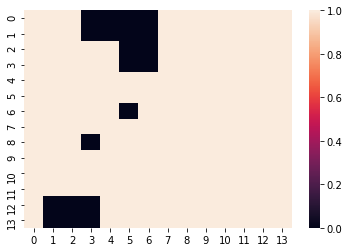

In [58]:
sns.heatmap(train_y[-88])

In [59]:
for i in range(354+279, 368+279):
        train_y[-i] = (1 - binary_dilation(1 - train_y[-i], iterations = 1))

In [60]:
#start = len(train_y) - 205
for i in range(79, 79+200):
        train_y[-i] = (1 - binary_dilation(1 - train_y[-i], iterations = 1))

In [61]:
train_y[train_y > 0.92] = 1.

In [62]:
#train_y[-200:][train_y[-200:] > 0.75] = 1.
train_y[-(107+279):-(97+279)][train_y[-(107+279):-(97+279)] < 0.7] = 0.

In [63]:
#val_loss, f1, error, haus, dice = calculate_metrics('all', al = 0.33, canopy_thresh = 75)
#save_path = saver.save(sess, f"{model_path}/24-{str(f1*100)[:2]}-{str(f1*100)[3]}/model")

In [ ]:
#### Epoch 1 to 30-50 should be 0.1
# Epoch 30-50+ should be 0.05
# Epoch 80+ should be 0.01
import tqdm

best_val = 0.6
fine_tune = False
countries['all'] = [0, len(test_x)]
ft_epochs = 0
train_ids = [x for x in range(len(train_y)) ]
batch, uniques = equibatch(train_ids)
f1 = 0.2
for i in range(2, 81):
    max_keep_rate = 0.5
    SWA = False
    fine_tune = False
    ft_learning_rate = 0.1# np.min([i * 0.02, 0.1])# 0.1#np.max([(.05) * (1 - (ft_epochs * .05)), 0.01])
    ft_epochs += 1
    #if i <= 100:
    #    ada  = 1 - ((100 - i) / (100 - 81))
    #    keeprate = 0.55 + (ada * 0.13)
    #
    if i >= 3:
        #SWA = True
        max_keep_rate = 0.5
    if i >= 60:
        max_keep_rate = 0.5
     #   max_keep_rate = np.minimum(0.4, max_keep_rate)

    #   SWA = True
    #    ft_learning_rate = 0.02
    #    max_keep_rate = 0.67
    al = np.min( [0.01 * (i - 1), 0.2] )
    print(f"{ft_learning_rate} LR, SWA: {SWA}")
    be = 0.0
    test_al = al
    if fine_tune == True:
        op = ft_op
        print(f"FINE TUNING WITH {ft_learning_rate} LR")
    else:
        op = train_step
        
    train_ids = [x for x in range(len(train_y))]
    randomize = train_ids
    randomize, uniques_i = equibatch(train_ids)
    overlap = len([x for x in uniques_i if x in uniques])
    print(f"This batch uses {overlap} of samples in previous batch")
    uniques = uniques_i
    
    loss = train_loss
    BATCH_SIZE = 32
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    keeprate = np.max(((1.05 - (i * 0.014)
                               ), max_keep_rate))
    keeprate = np.min((keeprate, 1))
    warm_up_steps = (i - 1) * 1000
    print(warm_up_steps)
    def calc_cosine_decay(epoch, maxepoch, offset):
        import math
        return 0.5 * (1 + math.cos(math.pi * (epoch - offset) / (maxepoch - offset)))
    if i < 100:           
        cosdec = calc_cosine_decay(i, 81, 0)
    adam_lr =  8e-4 * cosdec#(1 - ((i / 100))) * 1e-4
    ft_learning_rate = 8e-2 * cosdec#(1 - ((i / 100))) * 1e-2
    
    print(f"starting epoch {i}, alpha: {al}, beta: {be} drop: {keeprate}"
         f" Learning rate: {ft_learning_rate}")
    
    n_batch = int(len(randomize) // BATCH_SIZE)
    for k in range(int(len(randomize) // BATCH_SIZE)):#tqdm.notebook.trange(int(len(randomize) // BATCH_SIZE)):
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        x_batch, y_batch = augment_batch(batch_ids, BATCH_SIZE)
        warm_up_steps += 1
        if warm_up_steps < 2000:
            keeprate = 0.6 + (0.4 * (warm_up_steps / 2000))
            keeprate = np.min((keeprate, 1))
        if warm_up_steps < 6000:
            adam_lr = ((warm_up_steps) / 6000) * 1e-4
            ft_learning_rate= ((warm_up_steps) / 6000) * 1e-2
        if i == 1:
            if k % 20 == 0:
                print(keeprate, adam_lr)
        opt, tr = sess.run([op, loss], # op needs to be train_step for SAM
                          feed_dict={inp: x_batch,
                                     length: np.full((BATCH_SIZE,), LEN),
                                     labels: y_batch,
                                     is_training: True,
                                     loss_weight: 1.0,
                                     keep_rate: keeprate,
                                     alpha: al,
                                     beta_: be,
                                     init_lr: adam_lr,
                                     ft_lr: ft_learning_rate,
                                     })
        losses.append(tr)
        if k % 100 == 0 and k > 0:
            fp = evaluate_on_plots(x_batch_test2)      
        if k % 600 == 0 and k > 0:
            #fp = evaluate_on_plots(x_batch_test2)
            #if fp < 0.0:
            val_loss, f1, error, haus, dice = calculate_metrics('all', al = 0.33, canopy_thresh = 75)
            if f1 >= 0.90 and SWA:
                os.mkdir(f"{model_path}/2322-{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}-{str(k)}/")
                save_path = saver.save(sess, f"{model_path}/2322-{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}-{str(k)}/model")
                sess.run(swa_op)

    print(f"Epoch {i}: Loss {np.around(np.mean(losses[:-1]), 3)}")
    #if SWA:
        ##sess.run(save_weight_backups)
    #val_loss, f1, error, haus, dice = calculate_metrics('all', al = test_al, canopy_thresh = 75)
        #if f1 >= 0.905 or val_loss < 0.0995:
        ##    sess.run(swa_op)
            #sess.run(save_weight_backups)
            #sess.run(swa_to_weights)
    run_metrics = False
    metrics[0, i] = np.mean(losses[:-1])
    if f1 > 0.9:#(i > 80) and (i % 1) == 0:
        run_metrics = True
    elif i % 1 == 0:
        run_metrics = True
    if run_metrics:
        #if SWA:
            #sess.run(save_weight_backups)
            #sess.run(swa_to_weights)
        val_loss, f1, error, haus, dice = calculate_metrics('all', al = test_al, canopy_thresh = 75)
        metrics[1, i] = val_loss
        metrics[2, i] = error
        metrics[3, i] = haus
        metrics[4, i] = dice
        metrics[5, i] = f1
        if f1 >= 0.899 and SWA:
            sess.run(swa_op)
        if f1 < (best_val - 0.002):
            ft_epochs += 1
        if f1 > (best_val - 0.02):
            print(f"Saving model with {f1}")
            np.save(f"{model_path}/metrics.npy", metrics)
            os.mkdir(f"{model_path}/RESWA26-{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}/")
            save_path = saver.save(sess, f"{model_path}/RESWA26-{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}/model")
            if f1 > best_val:
                best_val = f1
    #if SWA:
        #if f1 > 0.9:
     #   sess.run(restore_weight_backups)

31005
[10503, 2648, 1833, 1549, 1592, 1671, 2006, 2267, 6936]
31005
This batch uses 26649 samples
64.35081472502125
987
993
[]
0.1 LR, SWA: False
31005
[10503, 2648, 1833, 1549, 1592, 1671, 2006, 2267, 6936]
31005
This batch uses 26636 samples
64.35081472502125
987
993
[]
This batch uses 993 of samples in previous batch
1000
starting epoch 2, alpha: 0.01, beta: 0.0 drop: 1.0 Learning rate: 0.07987971764671169
[-11.67968633 -30.7392227  -12.80473685  -7.75991551 -11.93753498]
[-13.36027156 -31.92040952 -15.81093648  -9.00783387 -16.21025989]
[-10.34247714 -27.57445194 -11.69524696  -7.02937017 -11.97110244]
[-11.16131082 -30.82540052 -12.28578313  -7.3903491  -12.93198069]
[-12.97554596 -33.1602241  -13.32662623  -7.55594047 -15.14500421]
[-15.27144784 -38.15233561 -14.81900355  -7.90905697 -16.49813798]
75
0.6172211883255413
all: Val loss: 0.17900000512599945 Thresh: 0.35 F1: 0.617 R: 0.846 P: 0.486 D: 0.5 H: 0.5 Error: 10.574
0.592929149510152
[ -9.83466193 -26.7012589   -9.56626845  

Epoch 7: Loss 0.3370000123977661
75
0.8127519508857576
all: Val loss: 0.15600000321865082 Thresh: 0.35 F1: 0.813 R: 0.842 P: 0.785 D: 0.5 H: 0.5 Error: 7.103
0.8106502025853753
Saving model with 0.8127519508857576
0.1 LR, SWA: False
31005
[10503, 2648, 1833, 1549, 1592, 1671, 2006, 2267, 6936]
31005
This batch uses 26641 samples
64.35081472502125
987
993
[]
This batch uses 993 of samples in previous batch
7000
starting epoch 8, alpha: 0.07, beta: 0.0 drop: 0.9380000000000001 Learning rate: 0.07808991541353662
[-61.5873659  -58.26557755 -59.35715067 -41.6925631  -78.12182966]
[ -7.7349952  -21.62233698  -7.44953575  -8.23866503 -10.86470229]
[-16.25797073 -29.3256281  -13.82798291 -10.0764034  -15.02600242]
[ -9.50394291 -24.37643974  -9.21726187  -9.54907981 -10.94775577]
[ -6.96916477 -16.40461638  -6.40459857  -5.9092955   -7.76473408]
[ -9.86343352 -25.04519565  -9.57620186 -10.29243156 -16.60664632]
75
0.8148398991609285
all: Val loss: 0.14300000667572021 Thresh: 0.35 F1: 0.815 R: 

[ -8.0706136  -35.18198251  -7.68138158  -9.0505631  -22.82674792]
Epoch 13: Loss 0.26600000262260437
75
0.8601904159917828
all: Val loss: 0.11699999868869781 Thresh: 0.35 F1: 0.86 R: 0.962 P: 0.778 D: 0.5 H: 0.5 Error: 5.391
0.8467064901517598
Saving model with 0.8601904159917828
0.1 LR, SWA: False
31005
[10503, 2648, 1833, 1549, 1592, 1671, 2006, 2267, 6936]
31005
This batch uses 26646 samples
64.35081472502125
987
993
[]
This batch uses 993 of samples in previous batch
13000
starting epoch 14, alpha: 0.13, beta: 0.0 drop: 0.8540000000000001 Learning rate: 0.07424667598121067
[-11.71252414 -38.89248006 -11.46944862 -10.23868718 -27.92864445]
[ -6.27811998 -29.32161613  -5.98109459  -7.05038245 -11.8033154 ]
[ -8.56415861 -34.0209567   -7.91004504  -8.27717085 -19.61512456]
[ -6.99955383 -36.15608507  -6.5843324   -8.18755037 -19.89128213]
[ -5.92154447 -29.99564257  -5.68311026  -7.15836527 -10.63272387]
[ -6.16819488 -24.98357964  -5.94950774  -6.43437158  -7.13860821]
75
0.84838974

[ -5.16714673 -30.09691021  -5.00402077  -6.0541253  -10.37372278]
[ -6.25785458 -36.41473415  -5.87185682  -9.15242434 -11.85366192]
[ -4.83941326 -25.83263285  -4.69899719  -6.01974747  -5.54911576]
[ -4.61556981 -30.78491691  -4.11036921  -4.69003913 -34.6115924 ]
Epoch 19: Loss 0.22599999606609344
75
0.8749467487703807
all: Val loss: 0.1120000034570694 Thresh: 0.35 F1: 0.875 R: 0.955 P: 0.807 D: 0.5 H: 0.5 Error: 4.897
0.8650292212920551
Saving model with 0.8749467487703807
0.1 LR, SWA: False
31005
[10503, 2648, 1833, 1549, 1592, 1671, 2006, 2267, 6936]
31005
This batch uses 26645 samples
64.35081472502125
987
993
[]
This batch uses 993 of samples in previous batch
19000
starting epoch 20, alpha: 0.19, beta: 0.0 drop: 0.77 Learning rate: 0.06855718938231598
[ -4.84221681 -34.89131207  -4.79834484  -6.32803914  -9.11744185]
[ -4.35581882 -29.34226178  -3.95449722  -5.92169187  -8.49553362]
[ -4.74439084 -19.5699681   -4.5227864   -5.11931442  -5.81464618]
[ -4.68496653 -29.15498465 

0.8921879174140365
[ -4.17839173 -36.48393382  -4.12566005  -6.94288234  -8.65713036]
[ -4.39566894 -26.62892177  -4.19808319  -5.67947495  -5.04351109]
[ -4.3651953  -36.32140412  -3.83439201  -5.28550346 -12.69437245]
[ -7.18492653 -39.97875181  -6.19437485 -10.4220363  -19.61374636]


In [ ]:
br = np.copy(train_y[-464:-(464-192)])
np.mean(br)
br[br < 0.4] = 0.
#br[br < 0.6] = br[br < 0.6] ** 0.5
#print(np.mean(br))
train_y[-464:-(464-192)] = br

In [ ]:
#sess.run(save_weight_backups)
#sess.run(swa_to_weights)
val_loss, f1, error, haus, dice = calculate_metrics('all', al = 0.33, canopy_thresh = 75)
save_path = saver.save(sess, f"{model_path}/swaout43-high-{str(f1*100)[:2]}-{str(f1*100)[3]}/model")
#sess.run(restore_weight_backups)
#i = '29m'
#np.save(f"{model_path}/metrics.npy", metrics)
#os.mkdir(f"{model_path}/swaft-{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}/")
#save_path = saver.save(sess, f"{model_path}/swaft-{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}/model")

In [ ]:
def _unapply2(x):
        _max = 0.35
        _min = 0.
        midrange = (_max + _min) / 2
        rng = 0.35
        return x * (rng / 2) + midrange
    
def _apply2(x):
    _max = 0.4
    _min = 0.
    x = np.clip(x, 0, 0.4)
    midrange = (_max + _min) / 2
    rng = 0.4
    return (x - midrange) / (rng / 2)

train_x[..., 10] = _unapply2(train_x[..., 10])
train_x[..., 10] = _apply2(train_x[..., 10])
test_x[..., 10] = _unapply2(test_x[..., 10])
test_x[..., 10] = _apply2(test_x[..., 10])

In [ ]:
start = 0


test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(18, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0., vmax = 0.9, cbar = False)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show

In [ ]:
train_ids = [x for x in range(len(train_y))]
diffs = np.zeros((len(train_ids), ))
for idx in tnrange(0, len(train_ids) - 16, 20):
    x_input = train_x[idx:idx + 20].reshape(20, 13, 28, 28, n_bands)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  #inp_median: median_input,
                                  length: np.full((20,), 12),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(20, 14, 14)
    y[y > 0.4] = 1.0
    y[y < 0.4] = 0.
    diff = np.sum(y, axis = (1, 2)) - np.sum(train_y[idx: idx + 20], axis = (1, 2))
    diffs[idx : idx + 20] = diff
    

data['diffs'] = diffs[:len(data)]
data.to_csv("data_diffs-swa75.csv")

In [ ]:
train_ids = [x for x in range(train_x.shape[0])]
#train_ids = [6792,7200,10805,12009,12037,12063,12158,12302]
#train_ids = bad_veg
start = 0
#start = len(train_ids) - 70
print(start)

In [ ]:
matrix_ids = [train_ids[start], train_ids[start + 1], train_ids[start + 2],
             train_ids[start + 3], train_ids[start + 4],
             train_ids[start + 5], train_ids[start + 6], train_ids[start + 7]]
preds = []
trues = []

print(matrix_ids)
for i in matrix_ids:
    idx = i
    x_input = x_batch_test2[idx].reshape(1, 5, 28, 28, n_bands)
    
    y = sess.run([fm], feed_dict={inp: x_input,
                                  length: np.full((1,), 4),
                                  is_training: False,
                                    })
    y = np.array(y).reshape(14, 14)    
    preds.append(y)
    print(np.mean(y))
    true = y_batch_test2[idx].reshape(14, 14)
    trues.append(true)
    
start += 8

to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]
multiplot(to_plot, nrows = 4, ncols = 4)

In [ ]:
#train_ids = np.argwhere(diffs > 100)

matrix_ids = [train_ids[start], train_ids[start + 1], train_ids[start + 2],
             train_ids[start + 3], train_ids[start + 4],
             train_ids[start + 5], train_ids[start + 6], train_ids[start + 7]]
preds = []
trues = []
#print(start//4)
print(matrix_ids)
#sess.run(swa_to_weights)
#sess.run(restore_weight_backups)
for i in matrix_ids:
    idx = i
    x_input = train_x[idx].reshape(1, 13, 28, 28, n_bands)
    
    #median_input = calc_median_input(x_input)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  length: np.full((1,), 12),
                                  is_training: False,
                                    })
    y = np.array(y).reshape(14, 14)    
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    
    #print(idx, (list(data.iloc[idx, 1])[0], list(data.iloc[idx, 2])[0]))#, np.array(new_model[idx[0]]),
        #  np.array(old_model)[idx[0]])
    #print(idx, data.iloc[idx, 0], data.iloc[idx, 1],      data.iloc[i, 2],)
    trues.append(true)
    
start += 8

to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]
multiplot(to_plot, nrows = 4, ncols = 4)
# 17382, 17409,17423

# Remove 17527
#17810, 17820
# rotation remove 17741, 17817, 17824, 17838

In [ ]:
remove4 = np.argwhere(np.mean(train_y[-146:], axis = (1, 2)) < 0.66).flatten()
remove4

#### 